In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfs = []
for name in ["../results_resnet18_imagenettewoof.csv",
             "../results_resnet18_synth.csv",
             "../results_resnet18_imagenet.csv",
             "../results_vgg11_imagenet.csv"]:
    df = pd.read_csv(name)
    # Replace all the Nans with 0s
    df = df.fillna(0)
    dfs.append(df)

# Concatenate the two dataframes
df = pd.concat(dfs, ignore_index=True)


# df = df[df["Predicted Label"] != df["Label"]]
# df = df[df["Label"] >= 10]

# Remove all the rows where attribution is GradCAMPlusPlus and metric is coherency
# print(df.shape)
# df = df[~((df["Attribution Method"] == "GradCAMPlusPlus") & (df["Metric"] == "coherency"))]
# print(df.shape)

# coherency_df = pd.read_csv("results_gradcam_coherency.csv")
# coherency_df = coherency_df.fillna(0)

# # # Concat the two dataframes
# df = pd.concat([df, coherency_df], ignore_index=True)
# print(df.shape)

# # If mixing method is '0', convert it to number
df["Mixing Method"] = df["Mixing Method"].replace("0", 0)
df = df[(df["Dataset"] == "imagenet") & (df["Model"] == "vgg11")]

# df.to_csv("results_mixed_TOTAL.csv", index=False)

In [2]:
df

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Metric,Upscale Method,Mixing Method,Value
400800,11872,237,172,vgg11,imagenet,GradCAMPlusPlus,features.20,road_combined,bilinearUpsampling,IdentityMix,0.000486
400801,11872,237,172,vgg11,imagenet,GradCAMPlusPlus,features.20,road_combined,bilinearUpsampling,MultiplierMix,0.000484
400802,11872,237,172,vgg11,imagenet,GradCAMPlusPlus,features.20,deletion_curve_AUC,bilinearUpsampling,IdentityMix,0.002199
400803,11872,237,172,vgg11,imagenet,GradCAMPlusPlus,features.20,deletion_curve_AUC,bilinearUpsampling,MultiplierMix,0.002199
400804,11872,237,172,vgg11,imagenet,GradCAMPlusPlus,features.20,insertion_curve_AUC,bilinearUpsampling,IdentityMix,0.002173
...,...,...,...,...,...,...,...,...,...,...,...
568795,45309,906,691,vgg11,imagenet,ScoreCAM,features.5,average_drop,bilinearUpsampling,MultiplierMix,0.000000
568796,45309,906,691,vgg11,imagenet,ScoreCAM,features.5,coherency,bilinearUpsampling,IdentityMix,0.966365
568797,45309,906,691,vgg11,imagenet,ScoreCAM,features.5,coherency,bilinearUpsampling,MultiplierMix,0.972612
568798,45309,906,691,vgg11,imagenet,ScoreCAM,features.5,complexity,bilinearUpsampling,IdentityMix,7791.297852


In [4]:
# Pivot the data to get 'average_drop' and 'insertion_curve_AUC' side-by-side
pivoted = df.pivot_table(
    index=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
           'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    columns='Metric',
    values='Value',
    aggfunc='mean'  # or 'mean' if there are duplicates and you want the mean
).reset_index()

pivoted["complexity"] = pivoted["complexity"].astype(float) / (224*224)
pivoted["average_drop"] = pivoted["average_drop"].astype(float) / 100

def compute_ADCC(row):
    if row['coherency'] > 0 and row['complexity'] < 1 and row['average_drop'] < 1:
        return 3 * ((1 / row['coherency']) + (1 / (1 - row['complexity'])) + (1 / (1 - row['average_drop']))) ** -1
    else:
        return None
    
def compute_ARCC(row):
    if row['coherency'] > 0 and row['complexity'] < 1 and row['road_combined'] < 1:
        return 3 * ((1 / row['coherency']) + (1 / (1 - row['complexity'])) + (1 / ((1 + row['road_combined'])/2))) ** -1
    else:
        return None
    
pivoted['ADCC'] = pivoted.apply(compute_ADCC, axis=1)
# Calculate the harmonic mean
# pivoted['ADCC'] = pivoted.apply(
#     lambda row: 3*((1/row['coherency']) + (1 / (1 - row["complexity"])) + (1 / (1 - row['average_drop'])))**-1
#     if (row['coherency']>0 and row["complexity"] < 1 and row["average_drop"] < 1 else None,
#     axis=1
# )
pivoted['ARCC'] = pivoted.apply(compute_ARCC, axis=1)

# pivoted["ARCC"] = pivoted.apply(
#     lambda row: 3*((1/row['coherency']) + (1 / (1 - row["complexity"])) + (1 / (1 - row['road_combined'])))**-1,
#     # if pd.notnull(row['average_drop']) and pd.notnull(row['insertion_curve_AUC']) else None,
#     axis=1
# )

In [5]:
# First, melt back the metric columns (including your new ADCC one)
melted = pivoted.melt(
    id_vars=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
             'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    value_vars=['average_drop', 'insertion_curve_AUC', 'deletion_curve_AUC', 'coherency', 'complexity', 'ADCC','road_combined', 'infidelity', "ARCC"],
    var_name='Metric',
    value_name='Value'
)

# Optional: sort or reset index if needed
melted = melted.sort_values(by=['Image Index', 'Metric']).reset_index(drop=True)

df = melted.copy()

In [6]:
methods = df["Attribution Method"].unique()
layers = df["Layer"].unique()
metrics = df["Metric"].unique()
upscale_methods = df["Upscale Method"].unique()
mixing_methods = df["Mixing Method"].unique()

In [7]:
print("Methods:", methods)
print("Layers:", layers)
print("Metrics:", metrics)
print("Upscale Methods:", upscale_methods)
print("Mixing Methods:", mixing_methods)

Methods: ['GradCAMPlusPlus' 'LayerCAM' 'ScoreCAM']
Layers: ['features.10' 'features.15' 'features.20' 'features.5']
Metrics: ['ADCC' 'ARCC' 'average_drop' 'coherency' 'complexity'
 'deletion_curve_AUC' 'infidelity' 'insertion_curve_AUC' 'road_combined']
Upscale Methods: ['bilinearUpsampling']
Mixing Methods: ['IdentityMix' 'MultiplierMix']


In [8]:
methods = [i for i in methods if i not in ["EigenCAM"]]

bilinearUpsampling
        Image Index  Label  Predicted Label  Model   Dataset  \
192             125      2                2  vgg11  imagenet   
194             125      2                2  vgg11  imagenet   
196             125      2                2  vgg11  imagenet   
198             125      2                2  vgg11  imagenet   
408             186      3                3  vgg11  imagenet   
...             ...    ...              ...    ...       ...   
215766        49921    998              987  vgg11  imagenet   
215976        49978    999              999  vgg11  imagenet   
215978        49978    999              999  vgg11  imagenet   
215980        49978    999              999  vgg11  imagenet   
215982        49978    999              999  vgg11  imagenet   

       Attribution Method        Layer      Upscale Method Mixing Method  \
192       GradCAMPlusPlus  features.10  bilinearUpsampling   IdentityMix   
194       GradCAMPlusPlus  features.15  bilinearUpsampling  

<Figure size 640x480 with 0 Axes>

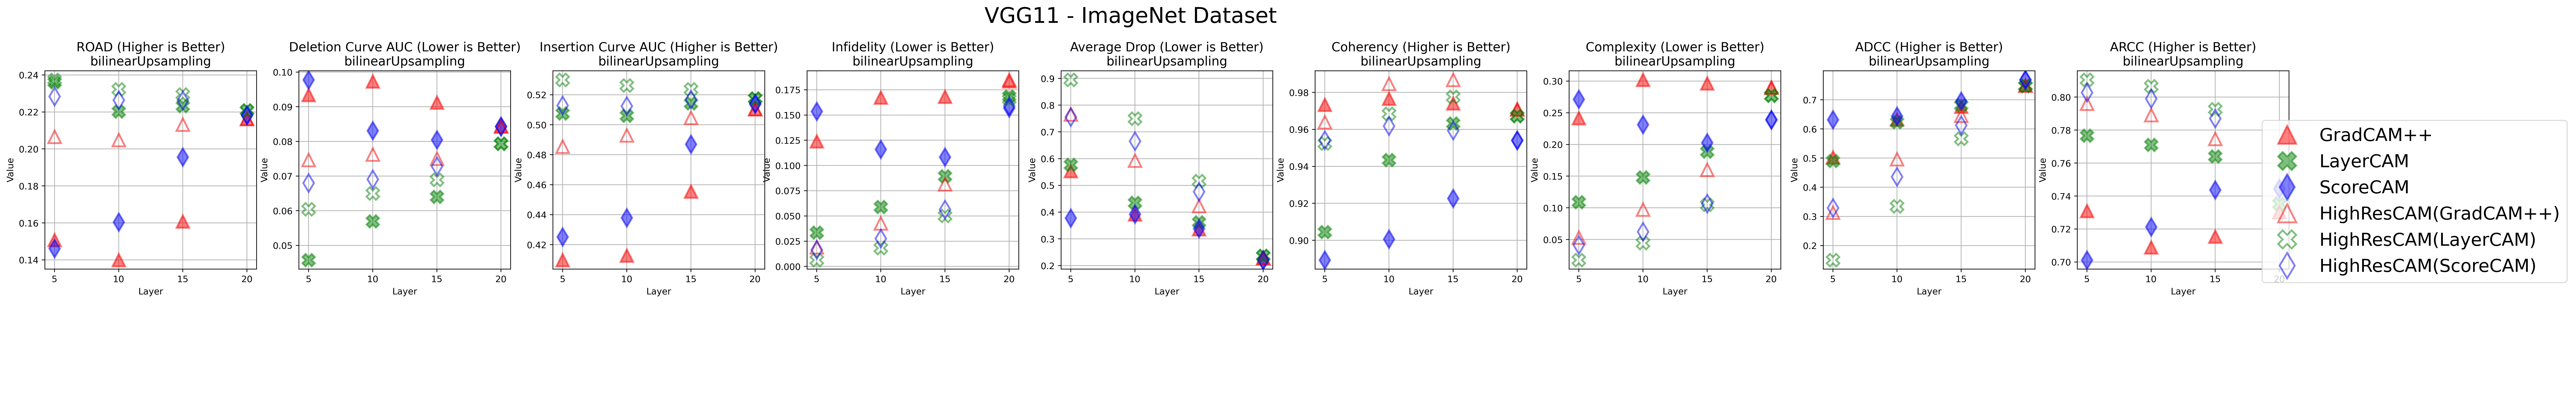

In [11]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.style.use('default')


# color_for_layers = ['#FF5733', '#33FF57', '#3385FF']  # Bright orange, green, and blue for better visibility on a black background
color_for_layers = ['r', 'g', 'b']
# shape_for_upscale = {"ERFUpsampling": "P","SimpleUpsampling": "D"}  # Define shape mapping
shape_for_methods = {"GradCAMPlusPlus": "^", "EigenCAM": "H", "LayerCAM": "X", "ScoreCAM": "d"}  # Define shape mapping

method_names = {"GradCAMPlusPlus": r"GradCAM++",
                "DeepLiftShap8": "DeepLiftShap Bilinear Upsampling",
                "LayerCAM": "LayerCAM",
                "EigenCAM": "EigenCAM",
                "ScoreCAM": "ScoreCAM"}
# upscale_names = {"ERFUpsampling": "ERF Upsampling", "SimpleUpsampling": "Bilinear Upsampling"}  # Define shape mapping
titles = {
    "sensitivity": "Sensitivity (Lower is Better)",
    "infidelity": "Infidelity (Lower is Better)",
    "road_combined": "ROAD (Higher is Better)",
    "ADCC": "ADCC (Higher is Better)",
    "ARCC": "ARCC (Higher is Better)",
    "average_drop": "Average Drop (Lower is Better)",
    "coherency": "Coherency (Higher is Better)",
    "complexity": "Complexity (Lower is Better)",
    "deletion_curve_AUC": "Deletion Curve AUC (Lower is Better)",
    "insertion_curve_AUC": "Insertion Curve AUC (Higher is Better)",
    "roc_auc": "ROC AUC (Higher is Better)",
    "mass_iou": "Mass IoU (Higher is Better)",
}

# fig.text(0.05, 0.75, 'GradCAM++', ha='center', va='center', fontsize=14) # , fontweight='bold')
# fig.text(0.05, 0.25, 'DeepLiftShap', ha='center', va='center', fontsize=14) # , fontweight='bold')

# plt.suptitle('Infidelity comparison between Filtered and NOT Filtered', fontsize=16)
plt.tight_layout()

metrics = ['road_combined',
# metrics = [
           'deletion_curve_AUC',
           'insertion_curve_AUC',
           'infidelity',
           'average_drop',
           'coherency',
           'complexity',
           'ADCC',
           "ARCC",]

upscale_methods = ["bilinearUpsampling"]

# metrics = ["road_combined"]

fig = plt.figure(figsize=(5*len(metrics),10), dpi=400)
plt.suptitle('VGG11 - ImageNet Dataset', fontsize=24)


for metric_index, metric in enumerate(metrics):
    df_metric = df[df["Metric"] == metric]
    # plt.subplot(3, 2,)
    for index, upscale in enumerate(upscale_methods):
        print(upscale)
        plt.subplot(2, len(metrics), index * len(metrics) + metric_index + 1)
        plt.title(titles[metric] + "\n" + upscale, fontsize=14)
        # for layer_type in types:
        for mix in mixing_methods:
            for j, attr_method in enumerate(methods):
                df_correct = df_metric[df_metric["Label"] == df_metric["Predicted Label"]]
                for df_index, grouped in enumerate([df_metric]):
                    res = grouped[(grouped["Upscale Method"] == upscale) &
                            (grouped["Attribution Method"] == attr_method) & 
                            (grouped["Mixing Method"] == mix)]
                    
                    print(res)
                    res = res.groupby("Layer").agg({"Value": ["mean","std","count"]}).reset_index()
                    # res["Layer"] = res["Layer"].apply(lambda x: int(x[-1]))
                    res["Layer"] = res["Layer"].apply(lambda x: int(x.split(".")[-1]))
                
                    if mix == "MultiplierMix":
                        # print("SimpleUpsampling")
                        plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method],markerfacecolor= 'none', color=color_for_layers[j], markersize=14,alpha=0.5, markeredgewidth=2)
                        # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                    else:
                        plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method], color=color_for_layers[j], markersize=14,alpha=0.5, markeredgewidth=2)
                        # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                        # print("ERFUpsampling")

                    plt.xlabel("Layer")
                    plt.ylabel("Value")
                    # Log scale for y
                    if metric == "sensitivity":
                        plt.yscale("log")

                    # plt.ylim([0.1, 0.3])
                    # if metric == "average_drop":
                        # plt.ylim([8, 80])
                    # elif metric == "insertion_curve_AUC":
                    #     plt.ylim([0.65, 0.71])
                    # elif metric == "deletion_curve_AUC":
                    #     plt.ylim([0.25, 0.36])
                    plt.grid(True)


        # Create color legend (Layer Types)
        # color_legend = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=10, label=layer) 
        #                 for color, layer in zip(color_for_layers, types)]
        color_legend = []

        # Create shape legend (Methods)
        # shape_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++"),
        #                 mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Only TP") 
        #                 ]
        
        upscale_legend = []
        
        # upscale_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered", markerfacecolor= 'none'),
        #                   mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered Only TP", markerfacecolor= 'none'),]
        
        # plt.xticks([1,2,3,4])
        plt.xticks([5,10,15,20])

shape_legend = [mlines.Line2D([], [], color=color_for_layers[j], marker=shape_for_methods[attr_method], linestyle='None', markersize=20, label=method_names[attr_method], alpha=0.5, markeredgewidth=2) 
            for j, attr_method in enumerate(methods)]

shape_legend_empty = [mlines.Line2D([], [], color=color_for_layers[j], marker=shape_for_methods[attr_method], linestyle='None', markersize=20, label=f"HighResCAM({method_names[attr_method]})", alpha=0.5, markerfacecolor='none', markeredgewidth=2)
            for j, attr_method in enumerate(methods)]

fig.legend(handles=shape_legend + shape_legend_empty, loc='center right', fontsize=20)
# fig.legend(handles=color_legend + shape_legend + upscale_legend, loc='center right', fontsize=10, bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, ncol=1)

plt.subplots_adjust(hspace=0.5)
# Invert all the color of the image
# plt.savefig('../output/results_synthetic_presentation.svg',format="svg", bbox_inches='tight', dpi=400)
plt.savefig('../output/results_vgg11_imagenet.pdf',format="pdf", bbox_inches='tight', dpi=400)


      Image Index  Label  Predicted Label  Model    Dataset  \
0               0      2                2  VGG11  Synthetic   
1               0      2                2  VGG11  Synthetic   
2               0      2                2  VGG11  Synthetic   
3               0      2                2  VGG11  Synthetic   
4               0      2                2  VGG11  Synthetic   
...           ...    ...              ...    ...        ...   
4795          149      3                3  VGG11  Synthetic   
4796          149      3                3  VGG11  Synthetic   
4797          149      3                3  VGG11  Synthetic   
4798          149      3                3  VGG11  Synthetic   
4799          149      3                3  VGG11  Synthetic   

     Attribution Method        Layer      Upscale Method         Metric  \
0              EigenCAM  features.10   ERFUpsamplingFast  road_combined   
1              EigenCAM  features.10  bilinearUpsampling  road_combined   
2              Eig

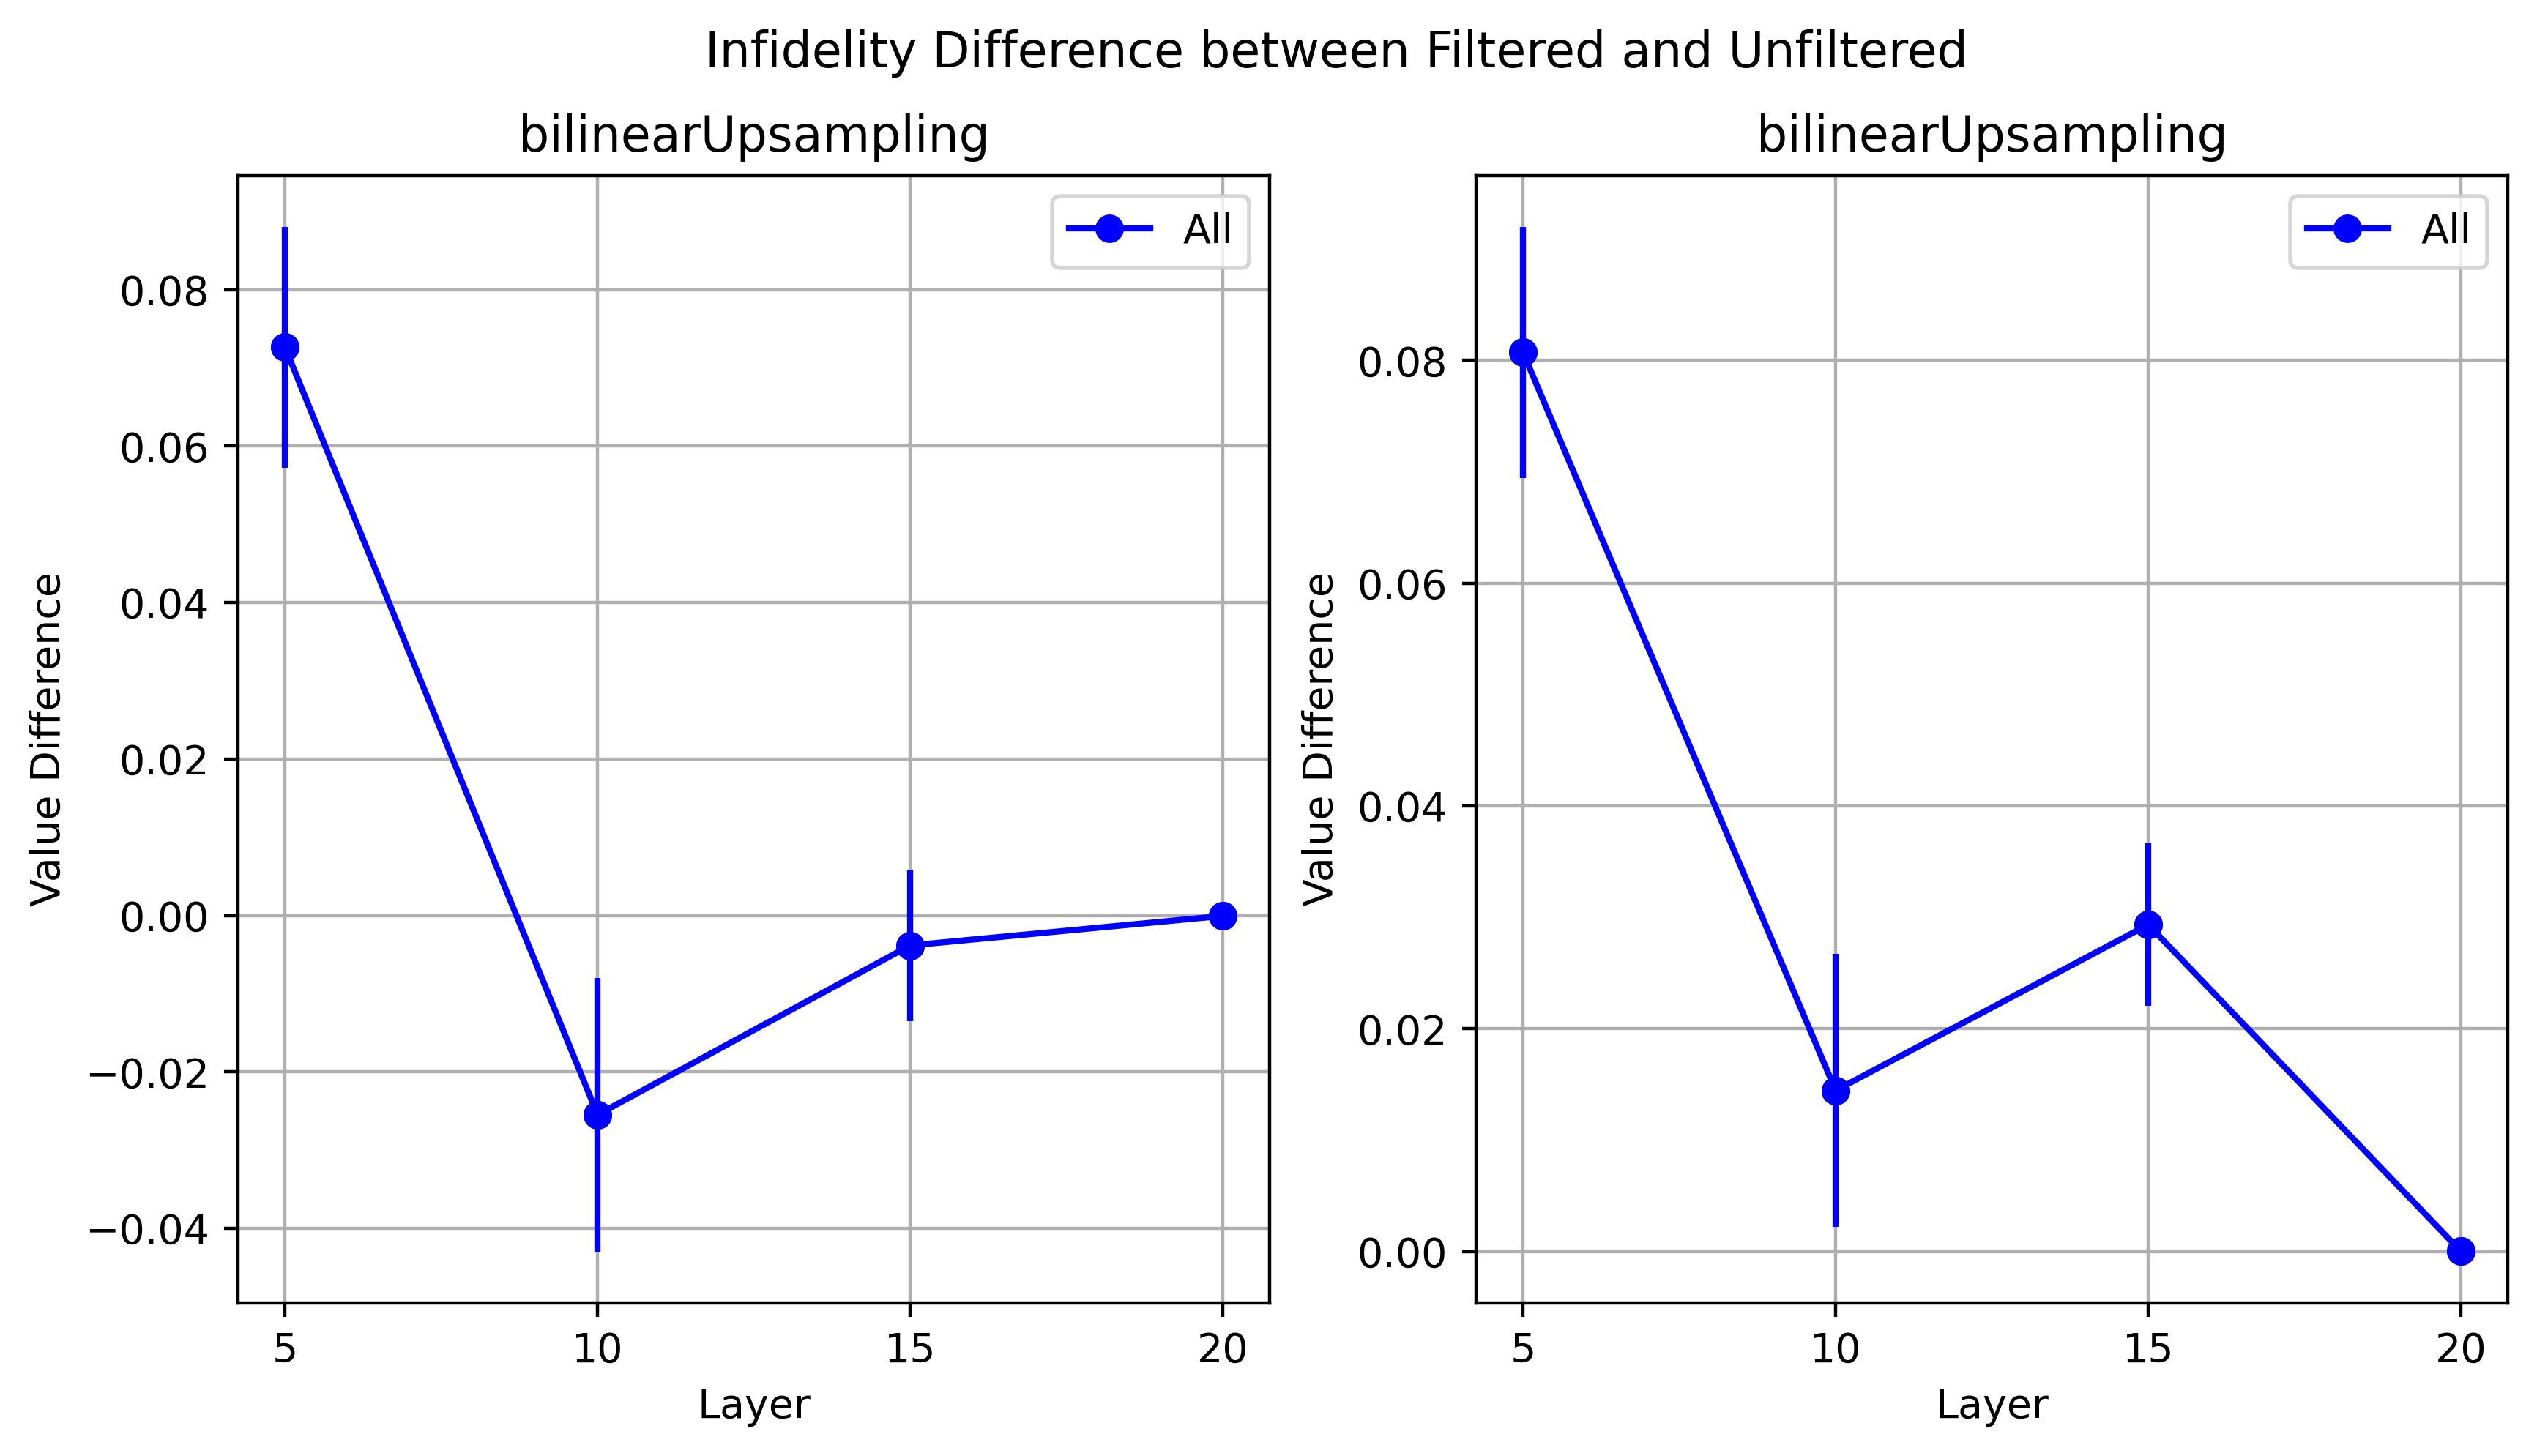

In [35]:
# Plot the grouped data showing also the 95% confidence interval
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import numpy as np


# Function to calculate the difference in 'Value' for each group
def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])


# Apply the function to each group and reset the index
# display(grouped)

plt.figure(figsize=(10,5), dpi=400)
plt.suptitle("Infidelity Difference between Filtered and Unfiltered")
# plt.xlabel("Layer")
# plt.ylabel("Value Difference")
# plt.xticks([5,10,15,20])
# plt.ylim([-0.1, 0.4])
# plt.grid(True)
# Plot data

for index, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), index + 1)
    plt.title(titles[metric])
    df_metric = df[df["Metric"] == metric]
    grouped = df_metric.groupby([col for col in df_metric.columns if col not in ['Mixing Method', 'Value']])

    # df_correct = df[df["Predicted Label"] == df["Label"]]
    # grouped_correct = df_correct.groupby([col for col in df_correct.columns if col not in ['Mixing Method', 'Value']])

    # df_wrong = df[df["Predicted Label"] != df["Label"]]
    # grouped_wrong = df_wrong.groupby([col for col in df_wrong.columns if col not in ['Mixing Method', 'Value']])

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    labels = ['All', 'Correctly Classified', 'Wrongly Classified']

    for index, upscale in enumerate(upscale_methods[:1]):
        # plt.subplot(1, 2, index + 1)
        plt.title(upscale)
        plt.grid(True)
        plt.xlabel("Layer")
        plt.ylabel("Value Difference")
        # plt.ylim([-0.01, 0.12])
        plt.xticks([5,10,15,20])
        
        grouped = grouped.apply(calculate_difference).reset_index()
        print(grouped)
        grouped = grouped[grouped["Upscale Method"] == upscale]        
        grouped = grouped.groupby(["Layer"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
        grouped["Layer"] = grouped["Layer"].apply(lambda x: int(x.split(".")[-1]))
        grouped = grouped.sort_values(by="Layer")
        plt.plot(grouped["Layer"], grouped['Value Difference']['mean'], marker='o', label=labels[index], color=colors[index])
        for i, row in grouped.iterrows():
            layer = int(row['Layer'].values[0])
            mean_diff = row['Value Difference']['mean']
            std_diff = 1.96*row['Value Difference']['std'] / np.sqrt(row['Value Difference']['count'])

            # Plot the mean difference with error bars
            plt.errorbar(layer, mean_diff, yerr=std_diff, fmt='o', color=colors[index])

        plt.legend()

# plt.savefig('results mixed difference infidelity.pdf', dpi=400, bbox_inches='tight')

C:\Users\Luca\AppData\Local\Temp\ipykernel_11708\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
C:\Users\Luca\AppData\Local\Temp\ipykernel_11708\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))


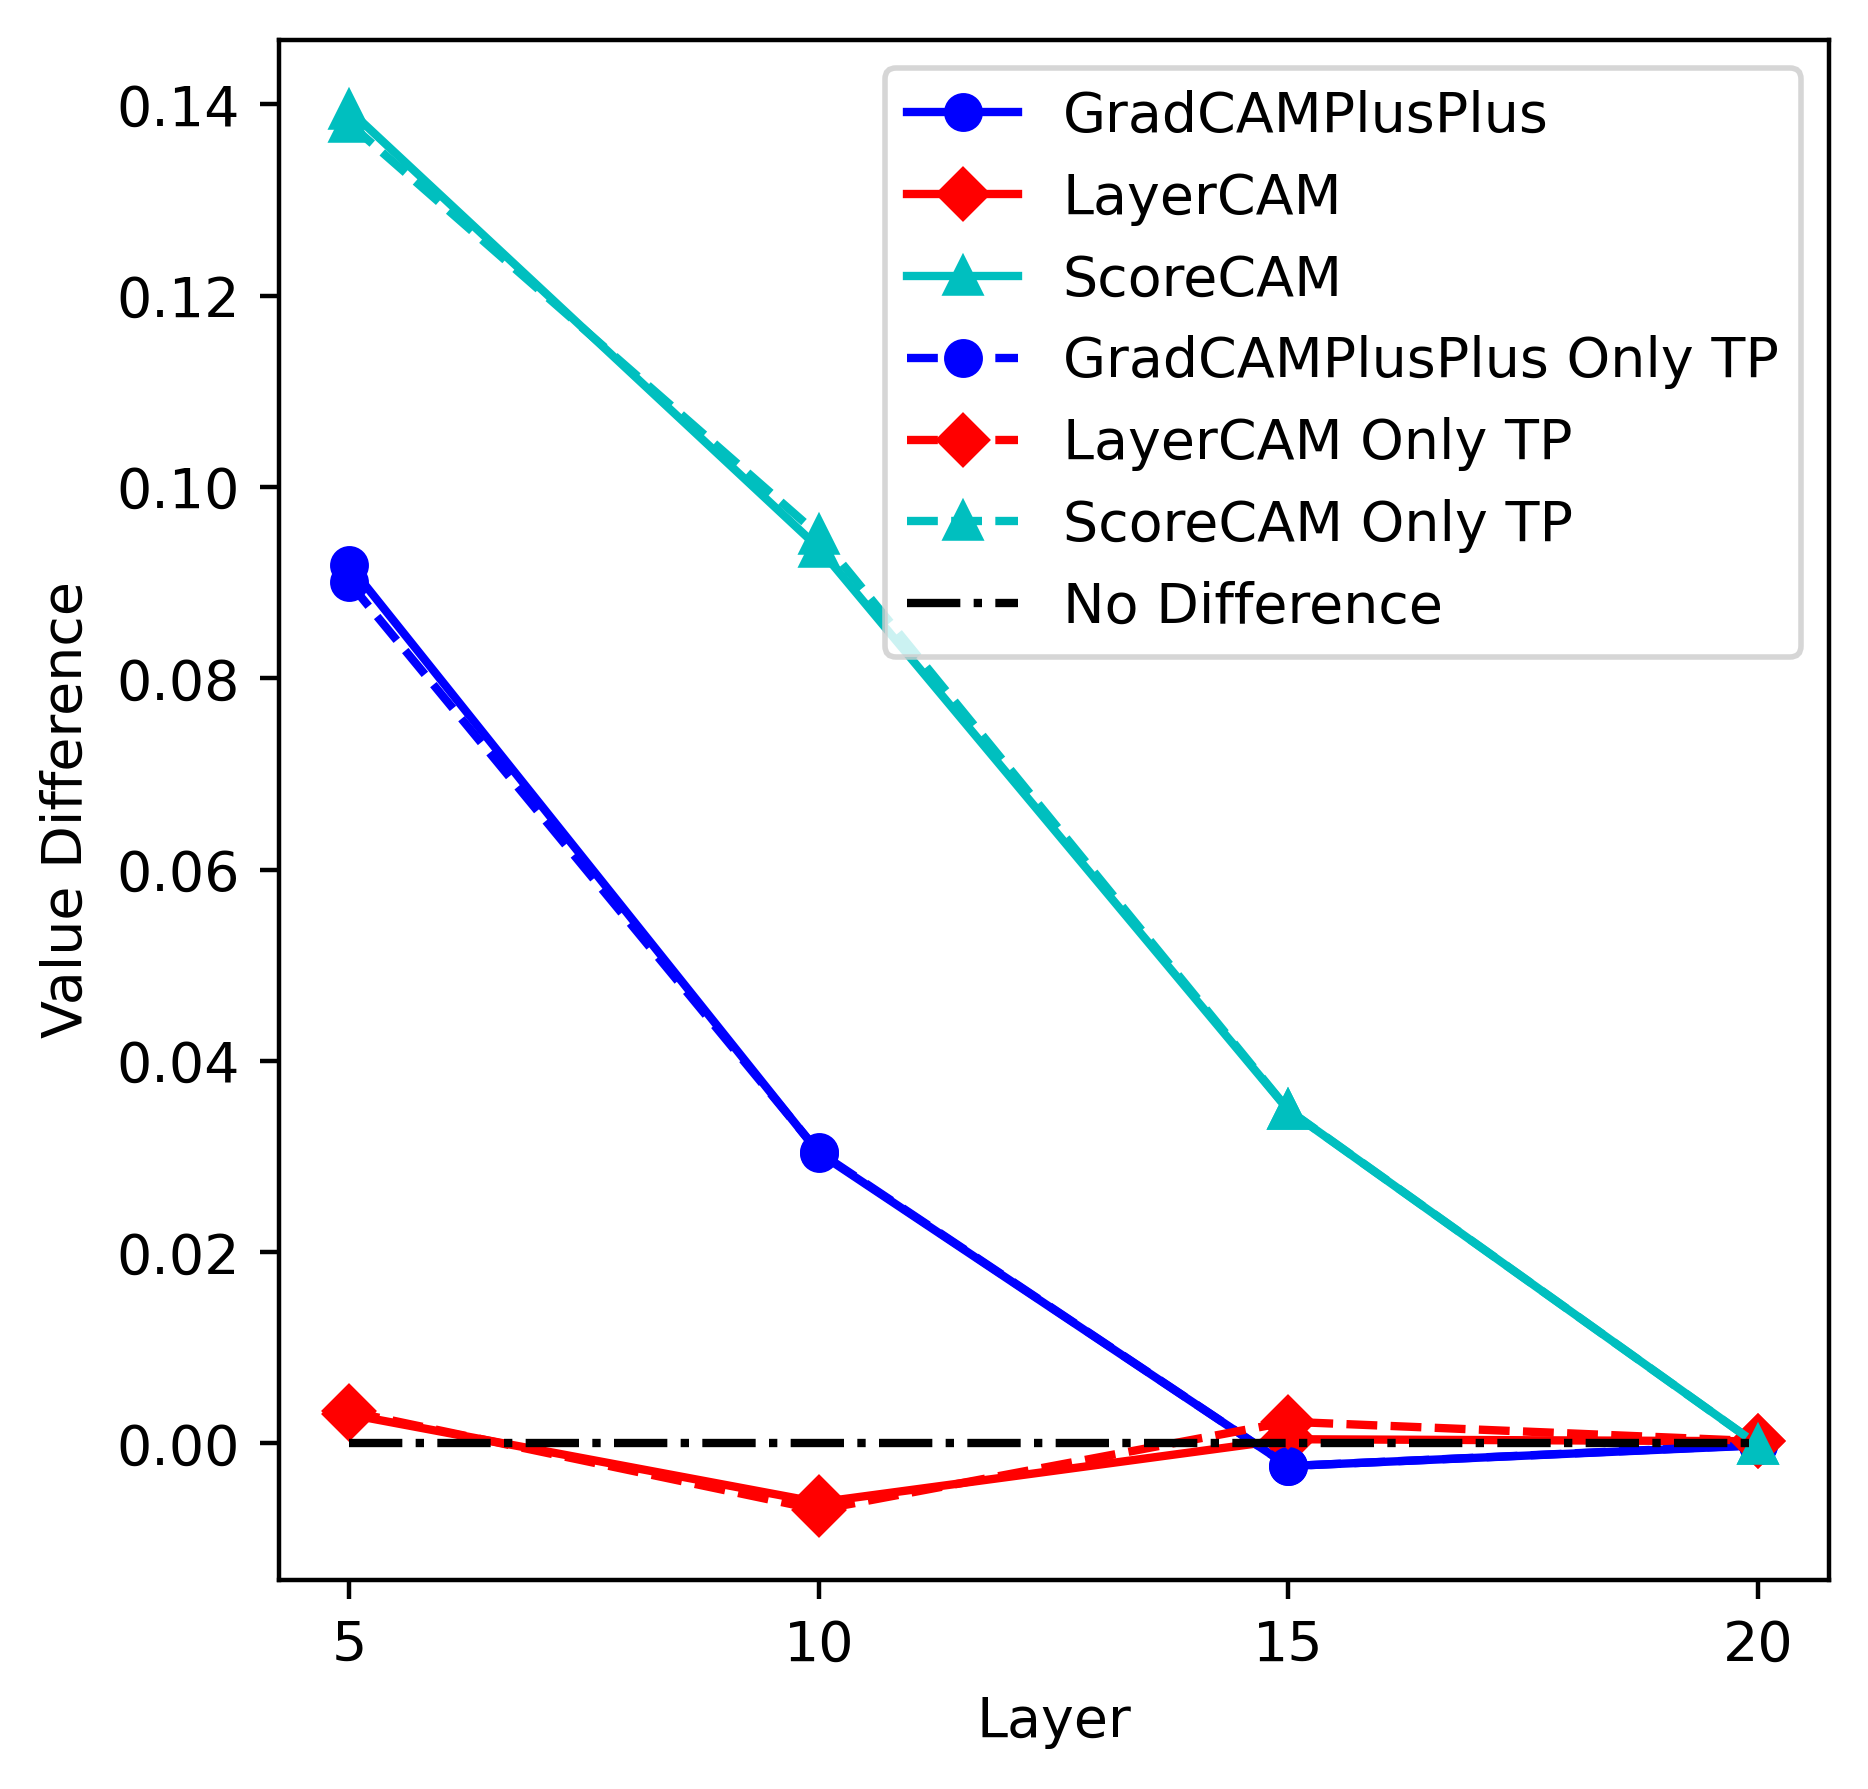

In [36]:
metrics = ["road_combined"]

def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])
    
marker_for_method = {
    "GradCAMPlusPlus": "o",
    "EigenCAM": "s",
    "LayerCAM": "D",
    "ScoreCAM": "^"}

color_for_method = {
    "GradCAMPlusPlus": "b",
    "EigenCAM": "g",
    "LayerCAM": "r",
    "ScoreCAM": "c"}

df_correct = df[df["Predicted Label"] == df["Label"]]
    
df_linestyles = ["-", "--"]

plt.figure(figsize=(5,5), dpi=400)

for df_index, d in enumerate([df, df_correct]):
    for metric in metrics:
        metric_df = d[d["Metric"] == metric]    
        grouped = metric_df.groupby([col for col in metric_df.columns if col not in ['Mixing Method', 'Value']]).apply(calculate_difference).reset_index()
        values = grouped.groupby(["Attribution Method", "Layer", "Upscale Method"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
        # display(values)

        for method in methods:
            for upscale in upscale_methods[:1]:
                filtered_values = values[(values["Attribution Method"] == method) & (values["Upscale Method"] == upscale)]

                filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
                filtered_values = filtered_values.sort_values(by="Layer")
                plt.plot(filtered_values["Layer"],
                         filtered_values['Value Difference']['mean'],
                         marker=marker_for_method[method],
                         label=method + (" Only TP" if df_index == 1 else ""),
                         linestyle=df_linestyles[df_index],
                         color=color_for_method[method])
                
                plt.xticks([5,10,15,20])
                plt.xlabel("Layer")
                plt.ylabel("Value Difference")
                # display(filtered_values)

plt.plot([5,10,15,20], [0,0,0,0], linestyle="dashdot", color="black", label="No Difference")
plt.legend()